**<h2>Mask R-CNN</h2>**

**Imports**

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\matth\anaconda3\envs\coco\lib\site-packages\tensorflow\python\frame

**Config**

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

**Create Model**

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

**Class Names**

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

**Object Detection**

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


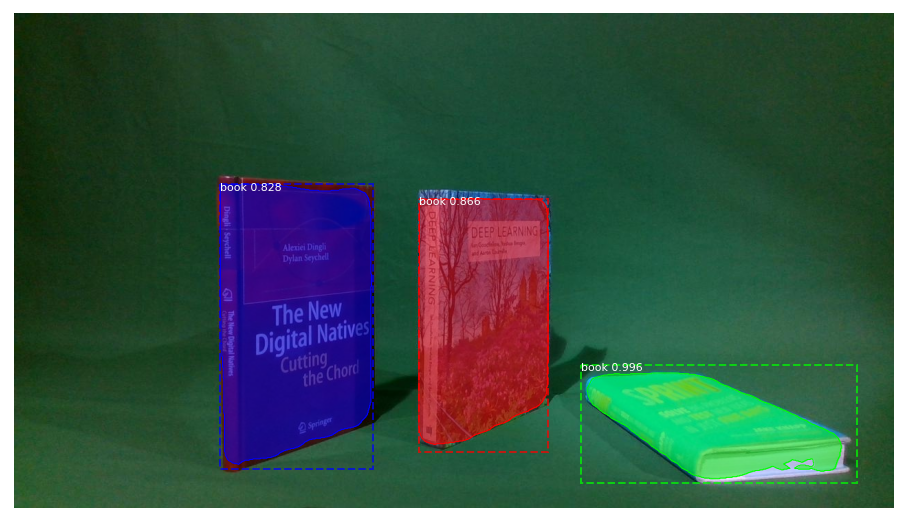

In [5]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

**Extract Masks**

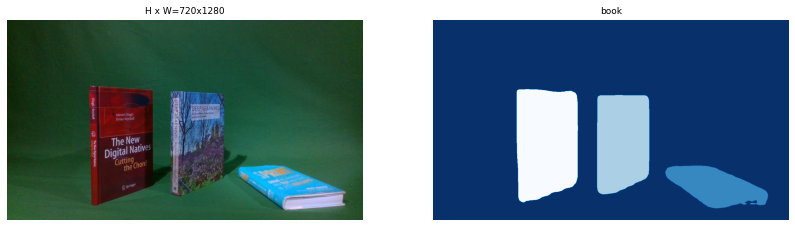

In [6]:
visualize.display_top_masks(image, r['masks'], r['class_ids'], 
                            class_names, limit=1)

**<h2>Itti's Saliency Map</h2>**

In [7]:
import cv2
import pySaliencyMap

In [8]:
im = cv2.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [9]:
def return_itti_saliency(img):
    '''
    Takes an image img as input and calculates the saliency map using the 
    Itti's Saliency Map Generator. It returns the saliency map.
    '''

    img_width, img_height = img.shape[1], img.shape[0]

    sm = pySaliencyMap.pySaliencyMap(img_width, img_height)
    saliency_map = sm.SMGetSM(img)

    # Scale pixel values to 0-255 instead of float (approx 0, hence black image)
    # https://stackoverflow.com/questions/48331211/how-to-use-cv2-imshow-correctly-for-the-float-image-returned-by-cv2-distancet/48333272
    saliency_map = cv2.normalize(saliency_map, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)

    return saliency_map

In [10]:
saliency_map = return_itti_saliency(im)

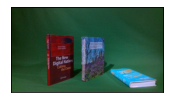

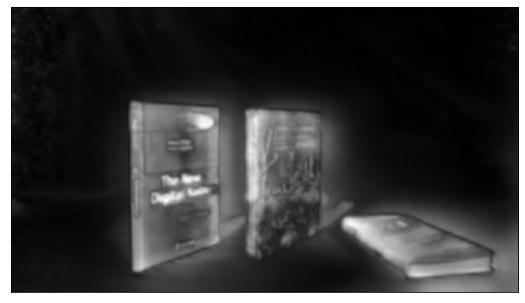

In [11]:
plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]

# show original and saliency map side by side
plt.subplot(121)
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

plt.subplot(122)
plt.imshow(saliency_map)
plt.xticks([])
plt.yticks([])
plt.gray()
plt.show()


**<h2>Saliency Ranking</h2>**

**Separate Masks**

In [12]:
masks = {}

mask_array = np.array(results[0]['masks'], dtype=np.uint8) * 255 
mask_array = cv2.cvtColor(mask_array, cv2.COLOR_RGB2GRAY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_array, connectivity=8)

for label in range(1, num_labels):
    object_mask = np.uint8(labels == label)
    masks[label] = {}
    masks[label]['mask'] = object_mask

**Calculate Score within each mask**

In [13]:
for label in masks.keys():
    masked_saliency_map = cv2.bitwise_and(saliency_map, saliency_map, mask=masks[label]['mask'])
    # Sum of pixel values divided by area of the mask
    masks[label]['score'] = np.sum(masked_saliency_map) / np.sum(masks[label]['mask'])

In [14]:
# sort masks by score and keep as dict
sorted_masks = {k: v for k, v in sorted(masks.items(), key=lambda item: item[1]['score'], reverse=True)}

**Output Results**

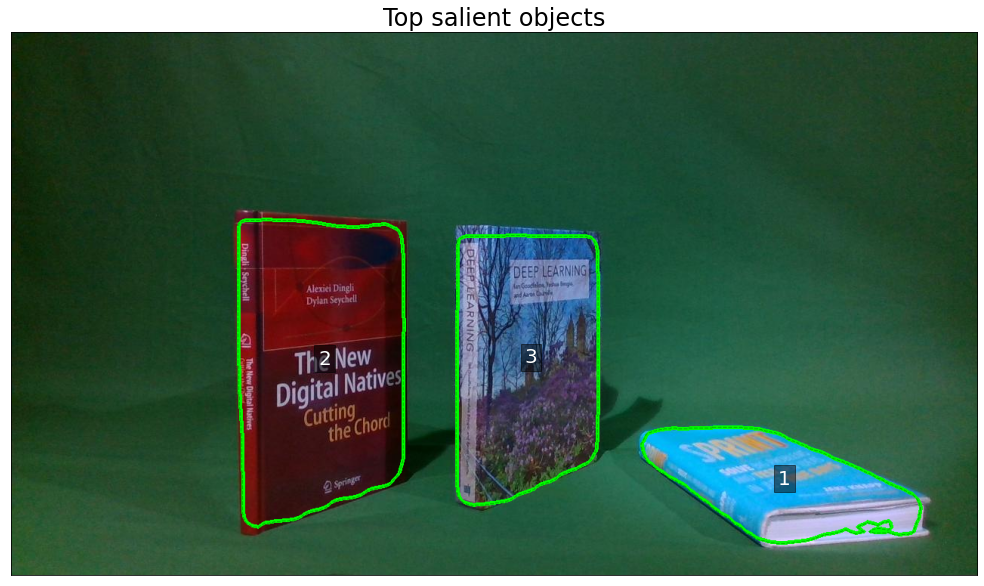

In [40]:
plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.title('Top salient objects')
plt.rcParams['axes.titlesize'] = 20


rank = 1

for label in sorted_masks.keys():
    # plot mask outline
    plt.contour(sorted_masks[label]['mask'], colors='green', linewidths=1, levels=[0.5], alpha=0.5, linestyles='dashed')

    # print('Object {} score: {}'.format(label, sorted_masks[label]['score']))

    # show object score on the image itself (truncate)
    t = plt.text(centroids[label][0], centroids[label][1], str(rank), color='white', fontsize=20)
    t.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='black'))

    rank += 1

plt.show()


    